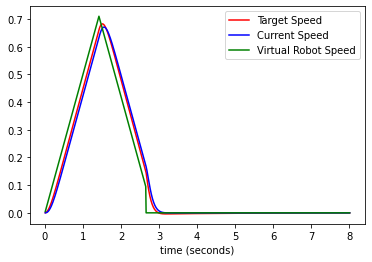

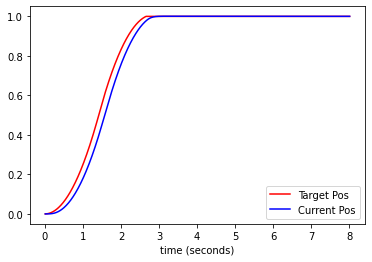

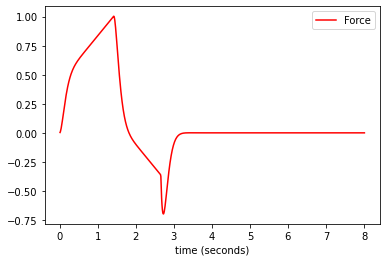

In [2]:
import sys
sys.path.append("../../")

from lib.data.dataplot import *
from lib.system.basic import *
from lib.system.controllers import *
from lib.system.cart import *
from lib.system.trajectory import *
from lib.utils.time import *

class PositionSpeedControl:
    
    def __init__(self, kp_pos, sat_pos, kp_speed, ki_speed, sat_speed):
        self.position_controller = P_Controller(kp_pos, sat_pos)
        self.speed_controller = PI_Controller(kp_speed, ki_speed, sat_speed)
        self.target_speed = 0
        
    def evaluate(self, delta_t, target_pos, current_pos, current_speed):
        pos_error = target_pos - current_pos
        self.target_speed = self.position_controller.evaluate(delta_t, pos_error)
        
        speed_error = self.target_speed - current_speed
        out = self.speed_controller.evaluate(delta_t, speed_error)
        return out
        

pos_dp = DataPlotter()
pos_dp.set_x("time (seconds)")
pos_dp.add_y("target", "Target Pos")
pos_dp.add_y("current", "Current Pos")

spd_dp = DataPlotter()
spd_dp.set_x("time (seconds)")
spd_dp.add_y("target", "Target Speed")
spd_dp.add_y("current", "Current Speed")
spd_dp.add_y("virtual", "Virtual Robot Speed")

f_dp = DataPlotter()
f_dp.set_x("time (seconds)")
f_dp.add_y("force", "Force")

cart = Cart(1.0, 0.8)

trajectory = VirtualRobot(1.,    # 4 meters
                        1.0,      # vmax = 1 m/s
                        0.5, 0.5) # acc = dec = 0.5 m/s 

ctrl = PositionSpeedControl(6.0, 1.0,     # PositionController: sat = 1 m/s
                            20.0, 10.0, 20.0) # Speed Controller: kp =20, ki = 10, sat = 20 N


t = Time(use_fake_time = True)
t.start()

current_speed = cart.speed
current_pos = cart.position

while t.get() < 8:
    
    t.sleep(0.01)
    delta_t = t.elapsed()
    
    trajectory.evaluate(delta_t)
    target_pos = trajectory.position()
    
    force = ctrl.evaluate(delta_t, target_pos, current_pos, current_speed)
    (current_pos, current_speed) = cart.evaluate(delta_t, force)
    
    spd_dp.append_x(t.get())
    spd_dp.append_y("target", ctrl.target_speed)
    spd_dp.append_y("current", current_speed)
    spd_dp.append_y("virtual", trajectory.speed())
    
    pos_dp.append_x(t.get())
    pos_dp.append_y("target", target_pos)
    pos_dp.append_y("current", current_pos)
    
    f_dp.append_x(t.get())
    f_dp.append_y("force", force)
    
spd_dp.plot()
pos_dp.plot()
f_dp.plot()
